In [1]:
# Set Working Directory
import os
os.chdir('..')

In [2]:
# Load Requirements
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, Normalizer, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.externals import joblib

from helper import *

In [3]:
# Load Data
wrangled_data = pd.read_csv('output/wrangled_data_ii.csv', dtype='str', na_values='NaN')

# Prep data for clustering

Before performing clustering, I created dummy variables for the categorical columns and converted numeric columns to float.

In [4]:
def prep_columns_cluster(wrangled_data_ii):
    """
    Return pandas dataframe of data prepped for clustering

    param dataframe wrangled_data_ii: dataframe of wrangled dataframe (after rename/reduce columns)
    """
    
    prepped_cluster_data = wrangled_data_ii.copy()
    
    # Identify column types
    identifying_columns = ['LEAID', 'NAME']
    prediction_columns = ['exist_five_years']
    categorical_columns = ['state_name', 'lowest_grade', 'highest_grade', 'metro_micro', 'charter_status']
    boolean_columns = ['bureau_indian_education']
    numerical_columns = []
    keep_features = ['total_students',
                     'total_schools',
                     'teachers_total',
                     'total_revenue',
                     'total_federal_revenue',
                     'total_state_revenue',
                     'total_local_revenue',
                     'total_expenditure',
                     'total_salaries',
                     'white_students',
                     'lowest_grade',
                     'highest_grade',
                     'metro_micro',
                     'charter_status',
                     'state_name',
                     'LEAID',
                     'NAME',
                     'exist_five_years']
    
    prepped_cluster_data = prepped_cluster_data[keep_features]
    
    # Identify numerical columns
    for column in prepped_cluster_data.columns:
        if column in identifying_columns or column in categorical_columns or column in boolean_columns or column in prediction_columns:
            pass
        elif len(prepped_cluster_data[column].unique()) > 100:
            numerical_columns.append(column)
        else:
            categorical_columns.append(column)
            
    # One-hot encode categorical variables
    prepped_cluster_data = pd.get_dummies(prepped_cluster_data, prefix_sep='_', columns=categorical_columns, drop_first=True)
    
    # Convert numerical columns to float
    prepped_cluster_data[numerical_columns] = prepped_cluster_data[numerical_columns].astype(float)

    # Remove identifying
    prepped_cluster_data.drop(columns=identifying_columns, inplace=True)
    y = prepped_cluster_data[prediction_columns]
    prepped_cluster_data.drop(columns=prediction_columns, inplace=True)
    X = prepped_cluster_data
    
    # Split into training, development, and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)
    X_dev, X_test, y_dev, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=21)
    
    return X_train, y_train, X_dev, y_dev, X_test, y_test

# Create 2D representation for visualization with PCA

To assess how well clusters are identified visually, I needed a 2-dimension representation of the dataset. I created this using PCA.

In [5]:
X_train, y_train, X_dev, y_dev, X_test, y_test = prep_columns_cluster(wrangled_data)

pca_pipeline = Pipeline([
    ('imp', Imputer(strategy='median')),
    ('scale', MinMaxScaler()),
    ('pca', PCA(n_components = 2))
])

prepped_data = pd.concat([X_train, X_dev, X_test])

pca_pipeline.fit(X_train)

Pipeline(memory=None,
     steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False))])

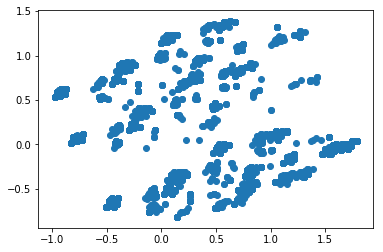

In [6]:
component_x = pca_pipeline.transform(prepped_data)[:, 0]
component_y = pca_pipeline.transform(prepped_data)[:, 1]

prepped_data['component_x'] = component_x
prepped_data['component_y'] = component_y

plt.scatter(prepped_data['component_x'], prepped_data['component_y'])

# Baseline K-means without missing data

I first established a baseline by performing clustering on the dataset without the missing data. I arbitrarily chose 20 as the number of clusters for the baseline.

In [7]:
X_train, y_train, X_dev, y_dev, X_test, y_test = prep_columns_cluster(wrangled_data)
X_train_woNA = X_train.dropna().copy()

Xy = X_dev.join(y_dev)
Xy = Xy.dropna()
y_dev_woNA = Xy['exist_five_years']
X_dev_woNA = Xy.drop(columns='exist_five_years').copy()

In [8]:
baseline_cluster_pipeline = Pipeline([
    ('cluster', KMeans(n_clusters=20, random_state=22))
])

baseline_cluster_pipeline.fit(X_train_woNA)

Pipeline(memory=None,
     steps=[('cluster', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=22, tol=0.0001, verbose=0))])

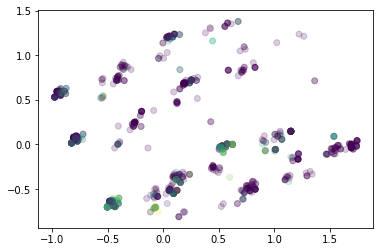

In [9]:
# Create 2D visualization
component_x = pca_pipeline.transform(X_dev_woNA)[:, 0]
component_y = pca_pipeline.transform(X_dev_woNA)[:, 1]
clusters = baseline_cluster_pipeline.predict(X_dev_woNA)
labels = y_dev_woNA.apply(lambda x: x=='False')

cluster_frame = pd.DataFrame({'component_x': component_x, 
                              'component_y': component_y, 
                              'cluster': clusters, 
                              'label': labels})
plt.scatter(cluster_frame['component_x'], cluster_frame['component_y'], c=cluster_frame['cluster'], alpha=0.2)

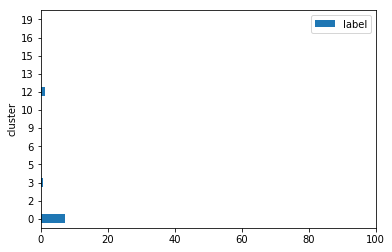

In [10]:
def percentage_under(values):
    return 100 * sum(values)/len(values)
cluster_frame[['cluster', 'label']].groupby('cluster').agg(percentage_under).plot.barh()
plt.xlim(0, 100)
plt.show()

The baseline clustering model did not create groupings with significantly more school districts at risk.

# Baseline K-means with missing data imputed

I tried improving on the baseline by imputing missing values.

In [11]:
impute_cluster_pipeline = Pipeline([
    ('imp', Imputer(strategy='median')),
    ('cluster', KMeans(n_clusters=20, random_state=22))
])

impute_cluster_pipeline.fit(X_train)

Pipeline(memory=None,
     steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('cluster', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=22, tol=0.0001, verbose=0))])

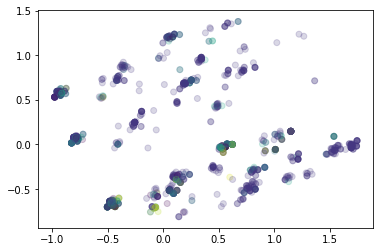

In [12]:
# Create 2D visualization
component_x = pca_pipeline.transform(X_dev)[:, 0]
component_y = pca_pipeline.transform(X_dev)[:, 1]
clusters = impute_cluster_pipeline.predict(X_dev)
labels = y_dev.apply(lambda x: x=='False').values.ravel()

cluster_frame = pd.DataFrame({'component_x': component_x, 
                              'component_y': component_y, 
                              'cluster': clusters, 
                              'label': labels})
plt.scatter(cluster_frame['component_x'], cluster_frame['component_y'], c=cluster_frame['cluster'], alpha=0.2)

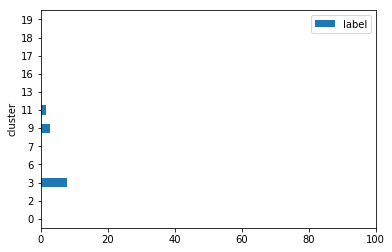

In [13]:
def percentage_under(values):
    return 100 * sum(values)/len(values)
cluster_frame[['cluster', 'label']].groupby('cluster').agg(percentage_under).plot.barh()
plt.xlim(0, 100)
plt.show()

Including missing values did not significant change the performance of the clustering model.

# Imputation and Normalization

I added normalization to try and improve the model.

In [14]:
normalize_cluster_pipeline = Pipeline([
    ('imp', Imputer(strategy='median')),
    ('normalizer', Normalizer()),
    ('cluster', KMeans(n_clusters=20, random_state=22))
])

normalize_cluster_pipeline.fit(X_train)

Pipeline(memory=None,
     steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('normalizer', Normalizer(copy=True, norm='l2')), ('cluster', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=22, tol=0.0001, verbose=0))])

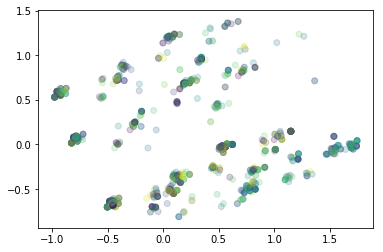

In [15]:
# Create 2D visualization
component_x = pca_pipeline.transform(X_dev)[:, 0]
component_y = pca_pipeline.transform(X_dev)[:, 1]
clusters = normalize_cluster_pipeline.predict(X_dev)
labels = y_dev.apply(lambda x: x=='False').values.ravel()

cluster_frame = pd.DataFrame({'component_x': component_x, 
                              'component_y': component_y, 
                              'cluster': clusters, 
                              'label': labels})
plt.scatter(cluster_frame['component_x'], cluster_frame['component_y'], c=cluster_frame['cluster'], alpha=0.2)

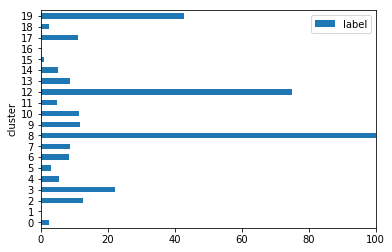

In [16]:
def percentage_under(values):
    return 100 * sum(values)/len(values)
cluster_frame[['cluster', 'label']].groupby('cluster').agg(percentage_under).plot.barh()
plt.xlim(0, 100)
plt.show()

In [17]:
for cluster in cluster_frame['cluster'].unique():
    closed = 100 * cluster_frame.loc[cluster_frame['cluster']==cluster, 'label'].sum()/len(cluster_frame[(cluster_frame['cluster']==cluster)])
    if closed > 35:
        print('cluster: {}, size: {}, closed percentage: {}'.format(cluster, len(cluster_frame[(cluster_frame['cluster']==cluster)]), closed))

cluster: 19, size: 7, closed percentage: 42.857142857142854
cluster: 12, size: 4, closed percentage: 75.0
cluster: 8, size: 3, closed percentage: 100.0


Including normalization significantly improved the groupings, and there are now two clusters with over 40 percent of school districts closing within 5 years.

# Tuning

I adjusted the n_clusters parameter to see how results would change.

#### 5 clusters

In [18]:
five_cluster_pipeline = Pipeline([
    ('imp', Imputer(strategy='median')),
    ('normalizer', Normalizer()),
    ('cluster', KMeans(n_clusters=5, random_state=22))
])

five_cluster_pipeline.fit(X_train)

Pipeline(memory=None,
     steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('normalizer', Normalizer(copy=True, norm='l2')), ('cluster', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=22, tol=0.0001, verbose=0))])

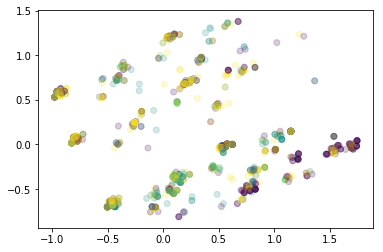

In [19]:
# Create 2D visualization
component_x = pca_pipeline.transform(X_dev)[:, 0]
component_y = pca_pipeline.transform(X_dev)[:, 1]
clusters = five_cluster_pipeline.predict(X_dev)
labels = y_dev.apply(lambda x: x=='False').values.ravel()

cluster_frame = pd.DataFrame({'component_x': component_x, 
                              'component_y': component_y, 
                              'cluster': clusters, 
                              'label': labels})
plt.scatter(cluster_frame['component_x'], cluster_frame['component_y'], c=cluster_frame['cluster'], alpha=0.2)

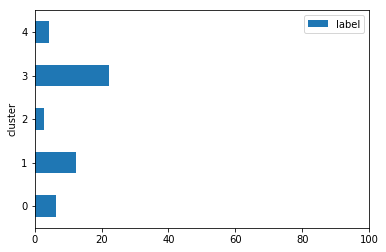

In [20]:
def percentage_under(values):
    return 100 * sum(values)/len(values)
cluster_frame[['cluster', 'label']].groupby('cluster').agg(percentage_under).plot.barh()
plt.xlim(0, 100)
plt.show()

In [21]:
for cluster in cluster_frame['cluster'].unique():
    closed = 100 * cluster_frame.loc[cluster_frame['cluster']==cluster, 'label'].sum()/len(cluster_frame[(cluster_frame['cluster']==cluster)])
    if closed > 35:
        print('cluster: {}, size: {}, closed percentage: {}'.format(cluster, len(cluster_frame[(cluster_frame['cluster']==cluster)]), closed))

#### 10 clusters

In [22]:
ten_cluster_pipeline = Pipeline([
    ('imp', Imputer(strategy='median')),
    ('normalizer', Normalizer()),
    ('cluster', KMeans(n_clusters = 10, random_state=22))
])

ten_cluster_pipeline.fit(X_train)

Pipeline(memory=None,
     steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('normalizer', Normalizer(copy=True, norm='l2')), ('cluster', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=22, tol=0.0001, verbose=0))])

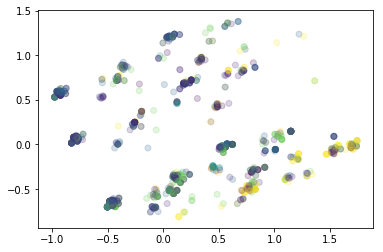

In [23]:
# Create 2D visualization
component_x = pca_pipeline.transform(X_dev)[:, 0]
component_y = pca_pipeline.transform(X_dev)[:, 1]
clusters = ten_cluster_pipeline.predict(X_dev)
labels = y_dev.apply(lambda x: x=='False').values.ravel()

cluster_frame = pd.DataFrame({'component_x': component_x, 
                              'component_y': component_y, 
                              'cluster': clusters, 
                              'label': labels})
plt.scatter(cluster_frame['component_x'], cluster_frame['component_y'], c=cluster_frame['cluster'], alpha=0.2)

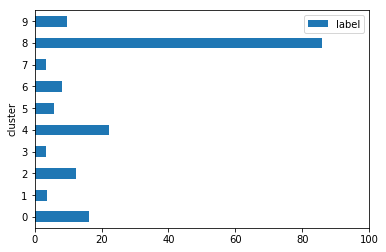

In [24]:
def percentage_under(values):
    return 100 * sum(values)/len(values)
cluster_frame[['cluster', 'label']].groupby('cluster').agg(percentage_under).plot.barh()
plt.xlim(0, 100)
plt.show()

In [25]:
for cluster in cluster_frame['cluster'].unique():
    closed = 100 * cluster_frame.loc[cluster_frame['cluster']==cluster, 'label'].sum()/len(cluster_frame[(cluster_frame['cluster']==cluster)])
    if closed > 35:
        print('cluster: {}, size: {}, closed percentage: {}'.format(cluster, len(cluster_frame[(cluster_frame['cluster']==cluster)]), closed))

cluster: 8, size: 7, closed percentage: 85.71428571428571


#### 50 clusters

In [26]:
fifty_cluster_pipeline = Pipeline([
    ('imp', Imputer(strategy='median')),
    ('normalizer', Normalizer()),
    ('cluster', KMeans(n_clusters=50, random_state=22))
])

fifty_cluster_pipeline.fit(X_train)

Pipeline(memory=None,
     steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('normalizer', Normalizer(copy=True, norm='l2')), ('cluster', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=50, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=22, tol=0.0001, verbose=0))])

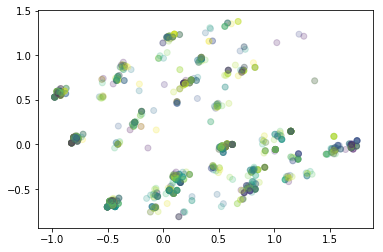

In [27]:
# Create 2D visualization
component_x = pca_pipeline.transform(X_dev)[:, 0]
component_y = pca_pipeline.transform(X_dev)[:, 1]
clusters = fifty_cluster_pipeline.predict(X_dev)
labels = y_dev.apply(lambda x: x=='False').values.ravel()

cluster_frame = pd.DataFrame({'component_x': component_x, 
                              'component_y': component_y, 
                              'cluster': clusters, 
                              'label': labels})
plt.scatter(cluster_frame['component_x'], cluster_frame['component_y'], c=cluster_frame['cluster'], alpha=0.2)

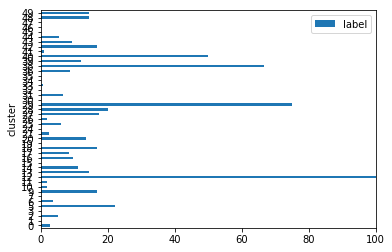

In [28]:
def percentage_under(values):
    return 100 * sum(values)/len(values)
cluster_frame[['cluster', 'label']].groupby('cluster').agg(percentage_under).plot.barh()
plt.xlim(0, 100)
plt.show()

In [29]:
for cluster in cluster_frame['cluster'].unique():
    closed = 100 * cluster_frame.loc[cluster_frame['cluster']==cluster, 'label'].sum()/len(cluster_frame[(cluster_frame['cluster']==cluster)])
    if closed > 35:
        print('cluster: {}, size: {}, closed percentage: {}'.format(cluster, len(cluster_frame[(cluster_frame['cluster']==cluster)]), closed))

cluster: 38, size: 3, closed percentage: 66.66666666666667
cluster: 29, size: 4, closed percentage: 75.0
cluster: 12, size: 3, closed percentage: 100.0
cluster: 40, size: 2, closed percentage: 50.0


# Use Features from EDA

## Insight

Having more clusters increased precision, but lowered recall. Since I prioritized recall over precision, I will choose the model with the highest recall (5 clusters).

In [89]:
five_cluster_pipeline = Pipeline([
    ('imp', Imputer(strategy='median')),
    ('normalizer', Normalizer()),
    ('cluster', KMeans(n_clusters=5, random_state=22))
])

five_cluster_pipeline.fit(X_train)

Pipeline(memory=None,
     steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('normalizer', Normalizer(copy=True, norm='l2')), ('cluster', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=22, tol=0.0001, verbose=0))])

In [90]:
filename = 'output/pipelines/cluster_pipeline.sav'
joblib.dump(five_cluster_pipeline, filename)

['output/pipelines/cluster_pipeline.sav']

In [91]:
X = pd.concat([X_train, X_dev, X_test])
y = pd.concat([y_train, y_dev, y_test])

In [92]:
clusters = five_cluster_pipeline.predict(X)
labels = y.apply(lambda x: x=='False').values.ravel()

cluster_frame = pd.DataFrame({'LEAID': wrangled_data.loc[X.index, 'LEAID'], 
                              'NAME': wrangled_data.loc[X.index, 'NAME'], 
                              'cluster': clusters, 
                              'label': labels})

In [93]:
cluster_frame.to_csv('output/cluster_results.csv', index=False)

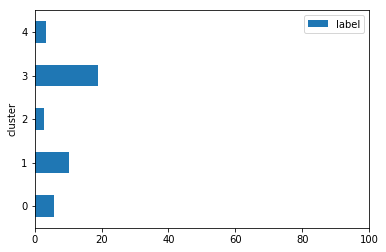

In [94]:
def percentage_under(values):
    return 100 * sum(values)/len(values)
cluster_frame[['cluster', 'label']].groupby('cluster').agg(percentage_under).plot.barh()
plt.xlim(0, 100)
plt.savefig('output/plots/clusters.jpg')